# Building and analysing a paper co-authorship network

In [1]:
import graph_tool_extras as gte
from pathlib import Path

import distribution as dst

from itertools import combinations
from random import random, choices, seed

from math import log

## Introduction

In this notebook, a network of Github developers in which the nodes are develpers and the edges, if they exist, are a follower releationship.

https://www.kaggle.com/datasets/rozemberczki/musae-github-social-network

The dataset was created with the aim of supporting the following comparative research about different social networks:

https://arxiv.org/pdf/1909.13021.pdf

In [2]:
FOLDER_PATH = Path.cwd() / 'archive'
EDGES_FILE_PATH = FOLDER_PATH / 'musae_git_edges.csv'

## Randomly limiting the Data

Given that the dataset exceded the maximium size requirement of this project, the data was limited by randomly selecting node's indexes. The list is turned to dictionary to reduce the time complexity of the loop inside while parsing the file.

In [3]:
seed(10)
listaNodesIndex = range(0, 37701)
chosenNodes = choices(listaNodesIndex, k=int(37700 / 1.2))
chosenNodesDict = dict.fromkeys(chosenNodes, None)

## Understanding the data

| Concept of vertices                  | Concept of edges                                            | Operationalization of vertices                                     | Operationalization of edges                                                | Description                                                                                                                                                                            |
|--------------------------------------|------------------------------------------------------------|---------------------------------------------------------------------|-------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Developers.                          | An edge between i and j means that i and j follow each other on GitHub. | Each vertex represents a developer that has starred at least 10 repositories. | All edges are undirected and exist only between nodes that mutually follow each other. | The graph was generated with the goal of binary classification. The classification task is to predict what type of developer the Github user is. The two types predicted are web developer or machine learning developer. The target feature (ground truth) of the classification was extracted from the job title of each user and the data was collected from the github public API in June 2019. |

## Creating functions to build the network

In [4]:
def get_or_add_vertex(g, id):
    u = g.vertex_by_id(id)
    if u is None:
        u = g.add_vertex_by_id(id)
    return u

In [5]:
def get_or_add_edge(g, author_a, author_b):
    e = g.edge_by_ids(author_a, author_b)
    if e is None:
        e = g.add_edge_by_ids(author_a, author_b)
    return e

## Reading the data and building the network

In [6]:
g = gte.Graph(directed=False)

In [7]:
with open(EDGES_FILE_PATH) as file:

    next(file)
    
    for line in file:
        parts = line.split(',')

        author_a = int(parts[0])
        author_b = int(parts[1].replace('\n', ''))

        if (author_a in chosenNodesDict and author_b in chosenNodesDict):
            vertex_a = get_or_add_vertex(g, author_a)
            vertex_b = get_or_add_vertex(g, author_b)
            edge = get_or_add_edge(g, author_a, author_b)

In [8]:
g = gte.clean(g)

In [15]:
g

<Graph object, undirected, with 19652 vertices and 100556 edges, 4 internal vertex properties, at 0x7f46e6641cd0>

In [9]:
gte.save(g, 'github_social.net.gz')

## Configuring the layout and rendering the network

In [10]:
from graph_tool import draw
import netpixi

In [11]:
layout = draw.sfdp_layout(g)

In [12]:
gte.move(g, layout)

In [13]:
gte.save(g, 'github_social_layout.net.gz')

In [14]:
r = netpixi.render('github_social_layout.net.gz', infinite=True)

## Improving network vizualization

In [16]:
r.vertex_default(
    size=1,
    color=0xff7700,
    bwidth=0.2,
    bcolor=0x0000ff,
)

In [17]:
r.edge_default(
    width=0.2,
    color=0xffffff,
    curve1=0,
    curve2=0,
)

## Calculating Density and Transitivity

In [18]:
g.density()

0.05

In [19]:
g.transitivity()

1.04

## Analysing Degree Distribution

In [20]:
degrees = g.get_total_degrees()

In [21]:
degrees.describe()

count    19652.000000
mean        10.233666
std         58.997740
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max       5344.000000
dtype: float64

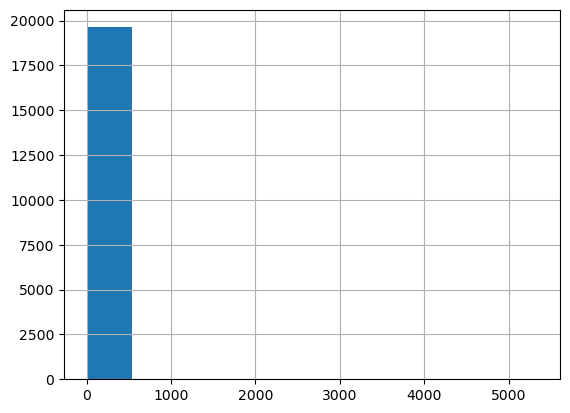

In [22]:
degrees.hist();

In [23]:
dst.not_normal(degrees)

0.0

In [24]:
dst.more_powerlaw_than_lognormal(degrees)

Calculating best minimal value for power law fit


/usr/local/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


(False, 0.14657149409085682)

In [25]:
dst.more_powerlaw_than_exponential(degrees)

Calculating best minimal value for power law fit


(True, 1.8598366623010217e-06)

## Analyzing Distance Distribution

In [26]:
distances = g.get_distances()

In [27]:
distances.describe()

count    3.862011e+08
mean     3.273040e+00
std      8.015005e-01
min      0.000000e+00
25%      3.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.200000e+01
dtype: float64

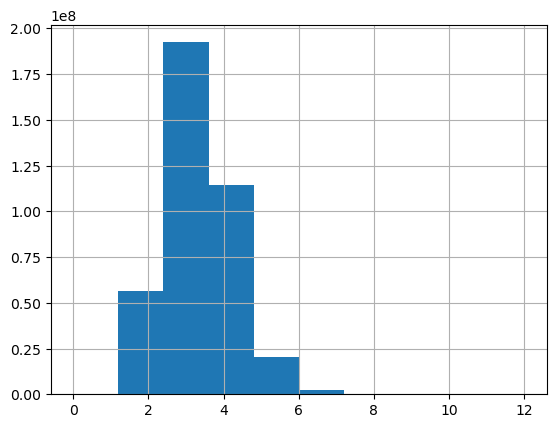

In [28]:
distances.hist();

In [29]:
log(g.num_vertices())

9.885934393288538